In [1]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def generate_truth(n_samples: int) -> np.ndarray:
    return np.random.normal(size=n_samples)

def confound(
    samples: np.ndarray,
    resolution: float,
) -> np.ndarray:
    noise = np.random.normal(loc=0., scale=resolution, size=samples.shape)
    return samples + noise

def generate_response(
    n_samples: int, 
    bins: list[float],
    resolution: float,
) -> np.ndarray:
    truth_data = np.random.normal(size=n_samples)
    truth_hist, _ = np.histogram(truth_data, bins=bins)
    observed_data = confound(truth_data, resolution=resolution)
    observed_hist, _ = np.histogram(observed_data, bins=bins)
    migrations, _, _ = np.histogram2d(observed_data, truth_data, bins=bins)
    response = migrations / truth_hist
    np.testing.assert_almost_equal(np.dot(response, truth_hist), observed_hist)
    return truth_hist, response

def generate_pseudoexperiment(
    n_samples: int,
    bins: list[float],
    resolution: float,
) -> dict[str, np.ndarray]:
    truth_data = generate_truth(n_samples)
    truth_hist, _ = np.histogram(truth_data, bins=bins)
    observed_data = confound(truth_data, resolution=resolution)
    observed_hist, _ = np.histogram(observed_data, bins=bins)
    return {"truth": truth_hist, "observed": observed_hist}

In [3]:
N = 10000
SMEAR = 0.3
BINS = [-np.inf, -3.25, -2, -1, -0.5, 0, 0.5, 1, 2, 3.25, np.inf]
N_PSEUDOEXPERIMENTS = 100

In [4]:
simulated_truth_hist, response = generate_response(n_samples=N*10, bins=BINS, resolution=SMEAR)
simulated_truth_hist = simulated_truth_hist / 10. # we use 10x luminosity to simulate the response 
pseudoexps = [
    generate_pseudoexperiment(n_samples=N, bins=BINS, resolution=SMEAR)
    for _ in range(N_PSEUDOEXPERIMENTS)
]

In [5]:
def compute_posterior(
    observed_hist: np.ndarray,
    response: np.ndarray,
    lower: np.ndarray,
    upper: np.ndarray,
) -> np.ndarray:
    model = pm.Model()

    with model:
        params = pm.DiscreteUniform(
            "params", 
            lower=lower, 
            upper=upper,
        )
        likelihood = pm.Poisson(
            "likelihood", mu=pm.math.dot(response, params),
            observed=observed_hist,
        )
        trace = pm.sample(draws=50000, tune=10000)
    return trace.posterior.params[0].to_numpy()

In [6]:
def plot_posterior(
    posterior: np.ndarray,
    truth_hist: np.ndarray,
    positions:list[float] = [-4.25, -2.75, -1.5, -0.75, -0.25, 0.25, 0.75, 1.5, 2.75, 4.25],
    xerr: list[float] = [1, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.75, 1],
):
    vp = plt.violinplot(
        posterior,
        positions=positions,
        showextrema=False,
    )
    eb = plt.errorbar(
        x=positions,
        y=truth_hist,
        xerr=xerr,
        fmt=".",
    )
    plt.legend([vp["bodies"][0], eb.lines], ["Posterior", "Truth"])
    plt.show()

In [7]:
pulls = []
for pseudoexp in tqdm(pseudoexps):
    posterior = compute_posterior(
        observed_hist=pseudoexp["observed"],
        response=response,
        lower=simulated_truth_hist // 10,
        upper=simulated_truth_hist * 10,
    )
    #plot_posterior(
    #    posterior=posterior,
    #    truth_hist=pseudoexp["truth"]
    #)
    pulls.append((posterior.mean(axis=0) - pseudoexp["truth"]) / posterior.std(axis=0))

  0%|          | 0/100 [00:00<?, ?it/s]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 17 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 93 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 193 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 17 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 18 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 17 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 44 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 124 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 912 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 440 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 913 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 912 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 977 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 919 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 267 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 316 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 919 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 14 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 13 seconds.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Output()

Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 152 seconds.


Text(0.5, 1.0, 'Pulls from 100 pseudo-experiments')

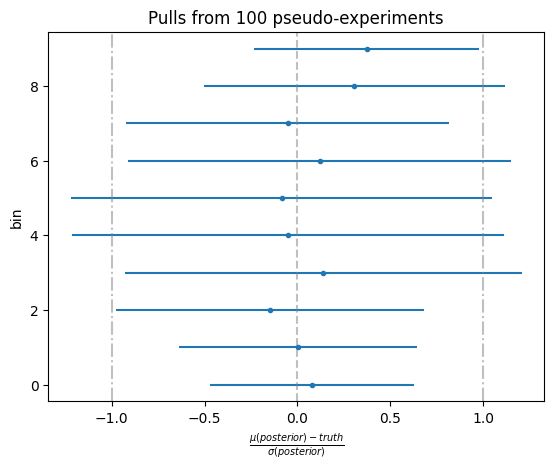

In [8]:
plt.errorbar(x=np.stack(pulls).mean(axis=0), y=np.arange(10), xerr=np.stack(pulls).std(axis=0), fmt=".");
plt.axvline(ymin=0, ymax=10, linestyle="--", color="gray", alpha=0.5);
plt.axvline(x=1, ymin=0, ymax=10, linestyle="-.", color="gray", alpha=0.5);
plt.axvline(x=-1, ymin=0, ymax=10, linestyle="-.", color="gray", alpha=0.5);
plt.xlabel(r"$\frac{\mu(posterior) - truth}{\sigma(posterior)}$");
plt.ylabel(r"bin");
plt.title(f"Pulls from {N_PSEUDOEXPERIMENTS} pseudo-experiments")